<a href="https://colab.research.google.com/github/soerenml/colab/blob/master/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Forecasting

Great introduction to RNN/LSTM: [link](https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9)

The following text is a summary based on Géron (2019) pp. 497-524.

### Formal description
A RNN could be described as a reflexive system based on recurrent neurons:

**x** describes a function's (**f()**) input vector while **y** describes the function's output. RNN are reflexive as they consume their previous output(s) (**x**<sub>t-1</sub>). Hence, output **y**<sub>t</sub> with with t = 2 would be a function of f(**x**<sub>t</sub> + **y**<sub>t-1</sub> + b) where **y**<sub>t-1</sub> = f(**x**<sub>t-1</sub>).

Including weights (K as activation function) for t=2 : 
**y**<sub>t</sub> = K(**W**<sub>x</sub><sup>T</sup>**x**<sub>t</sub> +
  **W**<sub>y</sub><sup>T</sup>**y**<sub>t-1</sub>+ **b**)

The following graphs highlights the structure of such a neuron: in this case the neuron refeeds in itself several times (t=3). The cell's output at time(t) is described as **state**.

![Source: Geron (2019)](https://www.oreilly.com/library/view/neural-networks-and/9781492037354/assets/mlst_1401.png)

### Memory cells
The reflixity shown above can also be interpreted as a form of memory: the neuron reminds itself of its previous states. 

### Input and output sequences

The follwoing image shows different forms of input and output sequences (from the top left to the bottom right):

+ Sequence to sequence
+ Sequence to vector
+ Vector to sequence
+ Encoder decoder

![Source: Geron (2019](https://www.oreilly.com/library/view/neural-networks-and/9781492037354/assets/mlst_1404.png)


In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt

In [0]:
# Helper function for plotting
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

In [0]:
# Generate training data
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    print(freq1)
    time = np.linspace(0, 1, n_steps) # define the time marks  [start, delta between steps, stop]
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

# The data has the form [batch_size, time_steps, ]


np.random.seed(42)

n_steps = 365
series = generate_time_series(2, n_steps + 1)


X_train, y_train = series[:1, :n_steps], series[:1, -1]
X_valid, y_valid = series[1:2, :n_steps], series[1:2, -1]
X_test, y_test = series[2:, :n_steps], series[2:, -1]

print(X_train)

[[0.37454012]
 [0.95071431]]
[[[-0.59067315]
  [-0.5971769 ]
  [-0.68082255]
  [-0.5984207 ]
  [-0.62228507]
  [-0.69197   ]
  [-0.70023996]
  [-0.70284885]
  [-0.6911013 ]
  [-0.6669936 ]
  [-0.6718802 ]
  [-0.67928904]
  [-0.6383812 ]
  [-0.6746884 ]
  [-0.6465244 ]
  [-0.6243591 ]
  [-0.59893656]
  [-0.5480128 ]
  [-0.58714366]
  [-0.53502476]
  [-0.5054688 ]
  [-0.53742504]
  [-0.4579488 ]
  [-0.4777344 ]
  [-0.46399218]
  [-0.3511212 ]
  [-0.32493243]
  [-0.31628206]
  [-0.34258747]
  [-0.3396626 ]
  [-0.2579856 ]
  [-0.260105  ]
  [-0.27048302]
  [-0.2127018 ]
  [-0.23937713]
  [-0.1336283 ]
  [-0.18164414]
  [-0.12550382]
  [-0.14613037]
  [-0.11217557]
  [-0.09773609]
  [-0.12348323]
  [-0.03588626]
  [-0.04748484]
  [-0.02442746]
  [-0.02343441]
  [-0.0487493 ]
  [-0.01296608]
  [-0.09380914]
  [-0.08134432]
  [-0.09536326]
  [-0.06682784]
  [-0.06036568]
  [-0.0722301 ]
  [-0.01673994]
  [-0.06416036]
  [-0.07179341]
  [-0.04535457]
  [-0.08481488]
  [-0.01738023]
  [-0.08811

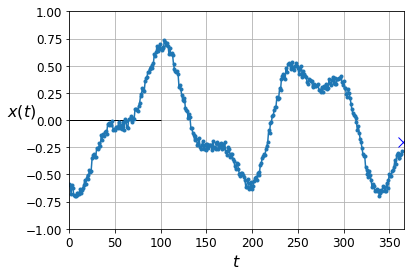

In [0]:
plot_series(X_train[0, :, 0], y_train[0, 0], None)
plt.show()

### Naive forecasting

In a first step we use a naive approach: t=t+1.
Hence, we assume no change from t to t+1.

In [0]:
y_pred = (X_valid[:,-1]) # t
naive_mse = np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

print("Naive MSE: {}".format(naive_mse))

Naive MSE: 0.0011687155347317457


### Deep RNN

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_valid, y_valid))

model.evaluate(X_valid, y_valid)

Epoch 1/20
1/1 [==============================] - 0s 250ms/step - loss: 0.5087 - val_loss: 0.0723
Epoch 2/20
1/1 [==============================] - 0s 50ms/step - loss: 0.2819 - val_loss: 0.0822
Epoch 3/20
1/1 [==============================] - 0s 48ms/step - loss: 0.0620 - val_loss: 0.0920
Epoch 4/20
1/1 [==============================] - 0s 50ms/step - loss: 0.0213 - val_loss: 0.0894
Epoch 5/20
1/1 [==============================] - 0s 50ms/step - loss: 0.0928 - val_loss: 0.0811
Epoch 6/20
1/1 [==============================] - 0s 47ms/step - loss: 0.1051 - val_loss: 0.0699
Epoch 7/20
1/1 [==============================] - 0s 48ms/step - loss: 0.0751 - val_loss: 0.0566
Epoch 8/20
1/1 [==============================] - 0s 50ms/step - loss: 0.0319 - val_loss: 0.0428
Epoch 9/20
1/1 [==============================] - 0s 54ms/step - loss: 0.0046 - val_loss: 0.0306
Epoch 10/20
1/1 [==============================] - 0s 49ms/step - loss: 4.2118e-04 - val_loss: 0.0212
Epoch 11/20
1/1 [=======

0.0017706349026411772

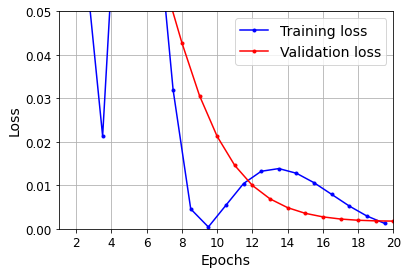

In [0]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

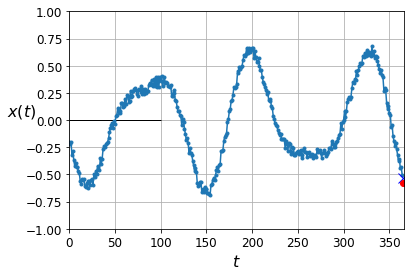

In [0]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Forecasting several steps ahead

In [0]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

Y_pred.shape

[[0.11505457]]


(1, 10, 1)

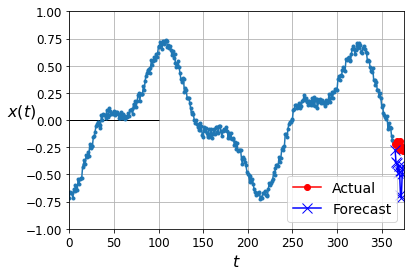

In [0]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# LSTM

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

[[0.37454012]
 [0.95071431]
 [0.73199394]
 ...
 [0.94670792]
 [0.39748799]
 [0.2171404 ]]
Epoch 1/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0553 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 8s 39ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0313 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0308 - last_time_s

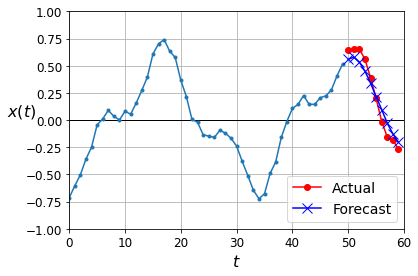

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()